In [502]:
!pip install pyxdf
!pip install mne
!pip install pandas
!pip install --upgrade jupyterlab ipympl ipywidgets
!pip install scikit-learn
!pip install seaborn


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [503]:
import sys
print(sys.version)

3.9.6 (default, Apr 30 2025, 02:07:17) 
[Clang 17.0.0 (clang-1700.0.13.5)]


In [504]:
import pyxdf
import numpy as np
import mne
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from psychopy_experiments.brand_associations.brands_wordlist import WORDLIST

In [505]:
instagram_wordlist = WORDLIST['instagram']
linkedin_wordlist = WORDLIST['linkedin']
unrelated_wordlist = WORDLIST['unrelated']
CATEGORY_MAP = {item: k for k, v in WORDLIST.items() for item in v}

In [506]:
csv_data = pd.read_csv('data/gio_brand.csv')
# csv_data = pd.read_csv('data/nani_n400.csv')
csv_data

,timestamp_iso,trial_index,brand,target,prime_time_s,target_time_s,resp_window_s,resp_key,rt_ms_from_target
0,2025-11-14T06:39:51.198,0,linkedin,ინფლუენსერი,0.16,0.16,1.5,NaN,NaN
1,2025-11-14T06:39:54.147,1,linkedin,ფოტოები,0.16,0.16,1.5,right,676.17
2,2025-11-14T06:39:57.093,2,linkedin,ინსპირაცია,0.16,0.16,1.5,right,1022.33
3,2025-11-14T06:40:00.107,3,instagram,ნეთვორქინგი,0.16,0.16,1.5,left,1573.17
4,2025-11-14T06:40:03.055,4,linkedin,სთორი,0.16,0.16,1.5,left,1613.88
...,...,...,...,...,...,...,...,...,...
235,2025-11-14T06:51:42.628,235,instagram,ვიოლინო,0.16,0.16,1.5,left,730.11
236,2025-11-14T06:51:45.558,236,linkedin,ლაქტოზა,0.16,0.16,1.5,left,1114.22
237,2025-11-14T06:51:48.489,237,linkedin,ნეთვორქინგი,0.16,0.16,1.5,left,897.35
238,2025-11-14T06:51:51.420,238,linkedin,მთები,0.16,0.16,1.5,left,997.26


In [507]:
csv_data['category'] = csv_data['target'].map(CATEGORY_MAP).fillna('unknown')

In [508]:
xdf_path = './data/gio_brand.xdf'
xdf_data = pyxdf.load_xdf(xdf_path)[0]
markers = xdf_data[0]
eeg = xdf_data[1]

In [509]:
# Redefine for Luka's data
# xdf_path = './data/luka_n400.xdf'
# xdf_data = pyxdf.load_xdf(xdf_path)[0]
# markers = xdf_data[0]
# eeg = xdf_data[1]

In [510]:
# Read marker data
marker_time = markers['time_stamps']
time_offset = marker_time[0]
marker_time = marker_time - time_offset
marker_data = [x[0] for x in markers['time_series']]

In [511]:
# n400_data = ExperimentData('data/nani_n400.xdf')

In [512]:
CONST_OFFSET = 0.073  # Delay measured with photodiode that day

In [513]:
eeg_time = eeg['time_stamps']
eeg_time = eeg_time - time_offset - CONST_OFFSET
eeg_data = eeg['time_series'][:, :8]

In [514]:
# Create raw data
info = mne.create_info(ch_names=['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8'], ch_types=['eeg'] * 8,
                       sfreq=250)
raw = mne.io.RawArray([1e-6 * eeg_data[:, i] for i in range(8)], info)
raw.notch_filter(freqs=[50])
raw.filter(0.5, 30)
raw

Creating RawArray with float64 data, n_channels=8, n_times=217056
    Range : 0 ... 217055 =      0.000 ...   868.220 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband a

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


<RawArray | 8 x 217056 (868.2 s), ~13.3 MB, data loaded>

In [515]:
TARGET_MARKER = 1
RESPONSE_MARKER = 2

In [516]:
events = []
for i, marker in enumerate(marker_data):
    eeg_start_index = np.argmax(eeg_time >= marker_time[i]) - 1
    events.append([eeg_start_index, 0, marker])
events = np.array(events)
# NOTE: We remove the last event because it is an artifact (end of recording)
events = events[:-1, :]

In [517]:
# Define reject criteria
reject_criteria = dict(
    eeg=70e-6,  # 100 µV
)

In [518]:
picks = ["Cz", "Pz"]
event_dict = dict(target=1)
tmin, tmax = -0.2, 1.01
epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=tmin, tmax=tmax, preload=True,
                    baseline=(None, 0 if tmin < 0 else None), picks=picks, reject=reject_criteria)

Not setting metadata
240 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 240 events and 303 original time points ...
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz', 'Pz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz', 'Pz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epo

In [519]:
# Get indices for non-rejected epochs
drop_log = epochs.drop_log
drop_log_not_ignored = [log for log in drop_log if 'IGNORED' not in log]
good_epoch_indices = [i for (i, log) in enumerate(drop_log_not_ignored) if len(log) == 0]

In [520]:
# Keep only non-rejected epochs from CSV data
csv_data = csv_data.iloc[good_epoch_indices].reset_index(drop=True)
csv_data

,timestamp_iso,trial_index,brand,target,prime_time_s,target_time_s,resp_window_s,resp_key,rt_ms_from_target,category
0,2025-11-14T06:39:51.198,0,linkedin,ინფლუენსერი,0.16,0.16,1.5,NaN,NaN,instagram
1,2025-11-14T06:39:54.147,1,linkedin,ფოტოები,0.16,0.16,1.5,right,676.17,instagram
2,2025-11-14T06:39:57.093,2,linkedin,ინსპირაცია,0.16,0.16,1.5,right,1022.33,instagram
3,2025-11-14T06:40:03.055,4,linkedin,სთორი,0.16,0.16,1.5,left,1613.88,instagram
4,2025-11-14T06:40:08.916,6,linkedin,ფოტოები,0.16,0.16,1.5,right,763.98,instagram
...,...,...,...,...,...,...,...,...,...,...
217,2025-11-14T06:51:42.628,235,instagram,ვიოლინო,0.16,0.16,1.5,left,730.11,unrelated
218,2025-11-14T06:51:45.558,236,linkedin,ლაქტოზა,0.16,0.16,1.5,left,1114.22,unrelated
219,2025-11-14T06:51:48.489,237,linkedin,ნეთვორქინგი,0.16,0.16,1.5,left,897.35,linkedin
220,2025-11-14T06:51:51.420,238,linkedin,მთები,0.16,0.16,1.5,left,997.26,unrelated


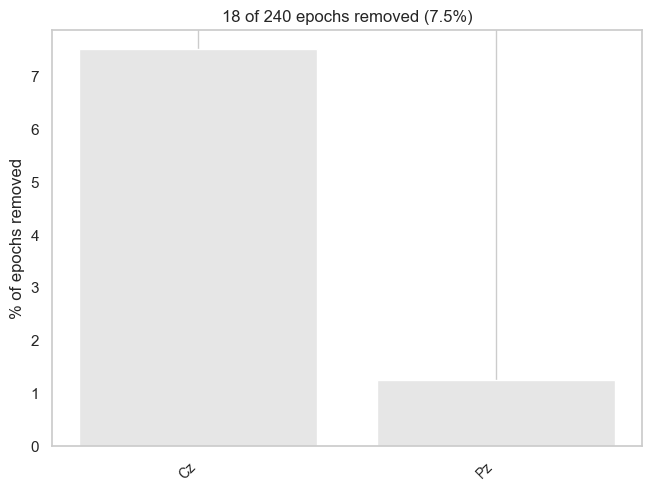

In [521]:
epochs.plot_drop_log(show=True);

In [522]:
# Optional: leave only first unique occurrence of each brand x target pairs
first_indices = csv_data[['brand', 'target']].drop_duplicates(keep='first').index.values
# first_indices = csv_data[['brand', 'target']].drop_duplicates(keep='last').index.values
csv_data = csv_data.iloc[first_indices].reset_index(drop=True)
epochs = epochs[first_indices]

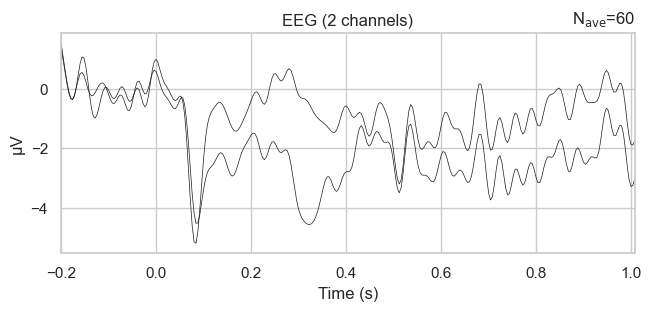

In [523]:
epochs.average().plot(picks=picks)
plt.show()

combining channels using "mean"


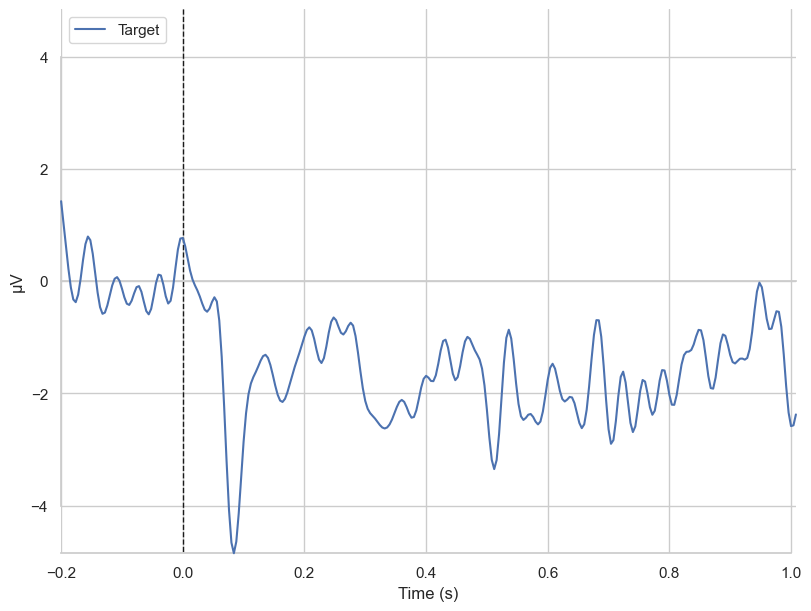

[<Figure size 800x600 with 1 Axes>]

In [524]:
mne.viz.plot_compare_evokeds(
    {"Target": epochs['target'].average()},
    combine='mean',
    show=True
)

In [525]:
instagram_idx = csv_data[csv_data['brand'] == 'instagram'].index.values
linkedin_idx = csv_data[csv_data['brand'] == 'linkedin'].index.values

instagram_words_idx = csv_data[csv_data['target'].isin(instagram_wordlist)].index.values
linkedin_words_idx = csv_data[csv_data['target'].isin(linkedin_wordlist)].index.values
unrelated_words_idx = csv_data[csv_data['target'].isin(unrelated_wordlist)].index.values

response_idx = csv_data[~csv_data['resp_key'].isna()].index.values

# Interesting epochs:
# 1. Everything with response
# 2. For each brand (facebook_idx, youtube_idx):
# 2.1. Facebook words (facebook_words_idx)
# 2.2. Youtube words (youtube_words_idx)
# 2.3. Shared words (shared_words_idx)
# 2.4. Unrelated words (unrelated_words_idx)
filt_ig_idx = np.intersect1d(response_idx, instagram_idx)
filt_li_idx = np.intersect1d(response_idx, linkedin_idx)
ig_ig_words_idx = np.intersect1d(filt_ig_idx, instagram_words_idx)
ig_li_words_idx = np.intersect1d(filt_ig_idx, linkedin_words_idx)
ig_un_words_idx = np.intersect1d(filt_ig_idx, unrelated_words_idx)
li_ig_words_idx = np.intersect1d(filt_li_idx, instagram_words_idx)
li_li_words_idx = np.intersect1d(filt_li_idx, linkedin_words_idx)
li_un_words_idx = np.intersect1d(filt_li_idx, unrelated_words_idx)
ig_instagram = epochs[ig_ig_words_idx]
ig_linkedin = epochs[ig_li_words_idx]
ig_unrelated = epochs[ig_un_words_idx]
li_instagram = epochs[li_ig_words_idx]
li_linkedin = epochs[li_li_words_idx]
li_unrelated = epochs[li_un_words_idx]

In [526]:
unrelated = np.intersect1d(response_idx, unrelated_words_idx)
# related_idx = np.union1d(fb_yt_words_idx, fb_sh_words_idx)
# related = np.intersect1d(response_idx, related_idx)
# related_unrelated = np.concatenate((related, unrelated))
# related_unrelated

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


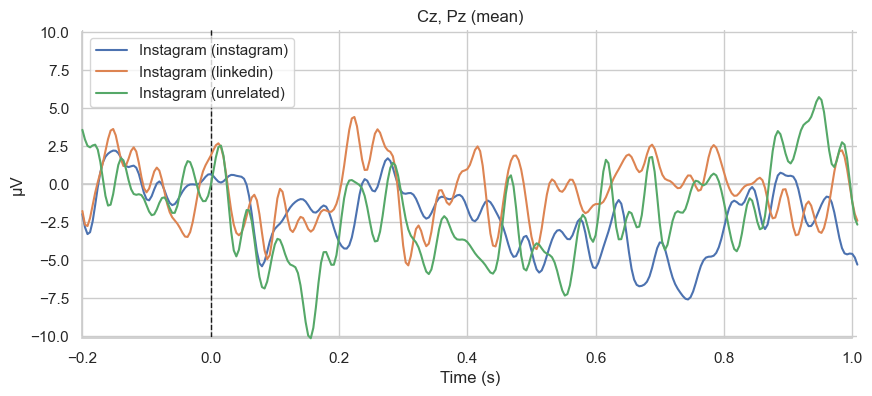

[<Figure size 1000x400 with 1 Axes>]

In [527]:
fig, ax = plt.subplots(figsize=(10, 4))
mne.viz.plot_compare_evokeds(
    {"Instagram (instagram)": ig_instagram.average(), "Instagram (linkedin)": ig_linkedin.average(),
    "Instagram (unrelated)": ig_unrelated.average()},
    picks=picks,
    combine='mean',
    show=True,
    axes=ax
)

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


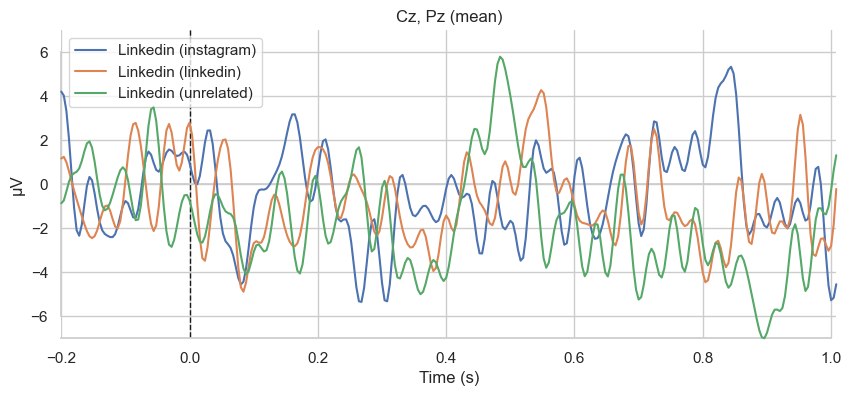

[<Figure size 1000x400 with 1 Axes>]

In [528]:
fig, ax = plt.subplots(figsize=(10, 4))
mne.viz.plot_compare_evokeds(
    {"Linkedin (instagram)": li_instagram.average(), "Linkedin (linkedin)": li_linkedin.average(),
    "Linkedin (unrelated)": li_unrelated.average()},
    picks=picks,
    combine='mean',
    show=True,
    axes=ax
)

In [529]:
import numpy as np
import mne
from sklearn.preprocessing import StandardScaler

# --------------------------------------------------------
# 0. Assume you already have:
#    - epochs: MNE Epochs, shape (n_trials, n_channels, n_times)
#    - epochs.metadata["category"] with values like "Television", "Relaxation", "Price", "Unrelated"
#    - epochs.metadata["subject"] with subject IDs
# --------------------------------------------------------

# 1) Select unrelated trials to build the N400 template
unrel_epochs = epochs[unrelated]
# if len(unrel_epochs) < 30:
#     raise ValueError(f"Not enough unrelated trials to build a template. ({len(unrel_epochs)})")

# 2) Compute the average ERP of unrelated trials
unrel_evoked = unrel_epochs.average()  # shape (n_channels, n_times)
data = unrel_evoked.data  # numpy array

In [530]:
# 3) Define N400 time window (adjust to your data!)
# typical N400: 300–500 ms
tmin_n400, tmax_n400 = 0.3, 0.5
tmask = (unrel_evoked.times >= tmin_n400) & (unrel_evoked.times <= tmax_n400)

# 4) Build temporal template = average over channels in N400 window
temporal_template = data.mean(axis=0)[tmask]  # shape (n_times_in_window,)
# normalize to avoid scaling issues
temporal_template = temporal_template / np.linalg.norm(temporal_template)

# 5) Build spatial template = average over time in N400 window
spatial_template = data[:, tmask].mean(axis=1)  # shape (n_channels,)
spatial_template = spatial_template / np.linalg.norm(spatial_template)

In [531]:
# (This gives us separate spatial and temporal “shapes” of the N400)

# --------------------------------------------------------
# 6) Now compute a single-trial N400 “score” for every NON-unrelated trial
#    We'll do a simple separable projection:
#    score = (spatial dot trial * temporal dot trial_window)
#    which mimics “how much this trial looks like the N400 template”.
# --------------------------------------------------------
# select trials we want to score
epochs_keep = epochs

n_trials = len(epochs_keep)
n400_scores = []

for ep in epochs_keep:  # ep: (n_channels, n_times)
    ep_data = ep
    # project spatially
    spatial_proj = np.dot(spatial_template, ep_data)  # shape (n_times,)
    # take N400 window
    trial_win = spatial_proj[tmask]
    # project temporally
    n400_val = np.dot(trial_win, temporal_template)   # scalar
    n400_scores.append(n400_val)

n400_scores = np.array(n400_scores)
n400_scores

array([ 5.85142293e-06, -2.94288327e-05,  1.97336381e-05, -4.01991437e-06,
        1.38966375e-04,  8.73358098e-05, -9.83484156e-05, -1.17329469e-04,
       -2.21820392e-05,  1.77758881e-05, -3.51433540e-05, -3.29687501e-05,
       -7.81923495e-05, -1.54661136e-05, -1.60387983e-05,  6.21568571e-06,
        8.76817822e-06,  7.03140990e-05, -4.12694301e-05,  3.09595631e-05,
       -2.89327644e-05, -6.61677437e-05, -9.40611187e-05, -1.75964815e-05,
        3.21191871e-06,  2.05637691e-05, -1.52196499e-05, -4.43163525e-05,
       -7.11122809e-05, -5.04891017e-05, -9.47334694e-05,  8.15109308e-06,
       -1.19664223e-04,  1.43545467e-05,  1.02236532e-04, -7.50830119e-05,
       -1.54363839e-04, -2.53483047e-05,  2.47215461e-05,  1.09506389e-04,
        1.84982182e-05, -2.17082626e-05,  1.93784296e-05, -1.46036011e-05,
        1.15095874e-05, -6.47988888e-05, -3.02184534e-05, -4.74962138e-05,
       -4.26146936e-05, -2.21286675e-05, -1.34268863e-05, -4.60219642e-05,
       -6.50220793e-05,  

In [532]:
# --------------------------------------------------------
# 7) Z-score per subject
# --------------------------------------------------------
n400_z = np.zeros_like(n400_scores, dtype=float)

# z-score
mean_ = n400_scores.mean()
std_ = n400_scores.std(ddof=1)
if std_ == 0:
    # fallback: no variance
    n400_z = 0.0
else:
    n400_z = (n400_scores - mean_) / std_

print(n400_z)

[ 0.44565078 -0.19981383  0.69963075  0.26505121  2.88103533  1.9364361
 -1.46072167 -1.80798668 -0.06723121  0.66381303 -0.30436299 -0.26457785
 -1.0919594   0.055639    0.04516153  0.45231509  0.49901383  1.62501795
 -0.41644169  0.90501297 -0.19073808 -0.87196504 -1.38228408  0.01666317
  0.39736012  0.71481829  0.06014814 -0.4721862  -0.96242707 -0.5851188
 -1.39458497  0.48772404 -1.85070182  0.60121839  2.20905002 -1.03507298
 -2.48554341 -0.12515914  0.79088627  2.34205459  0.67702831 -0.0585633
  0.69313209  0.07141896  0.54916887 -0.84692136 -0.21426021 -0.53036288
 -0.44105376 -0.06625475  0.09294737 -0.50339096 -0.85100471  0.53157704
  0.9194129   0.16809603  0.03047434  0.12748528 -0.63086752 -0.84288549]


In [533]:
# related_n400_z = n400_scores[:len(related)]
# unrelated_n400_z = n400_scores[len(related):]
# print(len(n400_scores), len(n400_scores))

In [534]:
# plt.boxplot([related_n400_z, unrelated_n400_z])
# plt.hist(unrelated_n400_z, bins=20, edgecolor='black')
# plt.title('Related vs Unrelated')
# plt.grid(axis='y', alpha=0.75)
# plt.show()

In [535]:
csv_data['score'] = n400_scores
csv_data['zscore'] = n400_z

In [536]:
# Build a translation table (Unicode codepoint → replacement string)
GE_TO_LAT = {
    ord('ა'): 'a',  ord('ბ'): 'b',   ord('გ'): 'g',   ord('დ'): 'd',
    ord('ე'): 'e',  ord('ვ'): 'v',   ord('ზ'): 'z',   ord('თ'): 't',
    ord('ი'): 'i',  ord('კ'): 'k',   ord('ლ'): 'l',   ord('მ'): 'm',
    ord('ნ'): 'n',  ord('ო'): 'o',   ord('პ'): 'p',   ord('ჟ'): 'zh',
    ord('რ'): 'r',  ord('ს'): 's',   ord('ტ'): "t'",  ord('უ'): 'u',
    ord('ფ'): "p'", ord('ქ'): "k'",  ord('ღ'): 'gh',  ord('ყ'): "q'",
    ord('შ'): 'sh', ord('ჩ'): 'ch',  ord('ც'): 'ts',  ord('ძ'): 'dz',
    ord('წ'): "ts'",ord('ჭ'): "ch'", ord('ხ'): 'kh',  ord('ჯ'): 'j',
    ord('ჰ'): 'h',
}

def georgian_to_latin_series(s: pd.Series) -> pd.Series:
    return s.astype(str).str.translate(GE_TO_LAT)

csv_data['target_latin'] = georgian_to_latin_series(csv_data['target'])
pdata = csv_data.groupby(['brand', 'category', 'target_latin'])[['score', 'zscore']].mean()

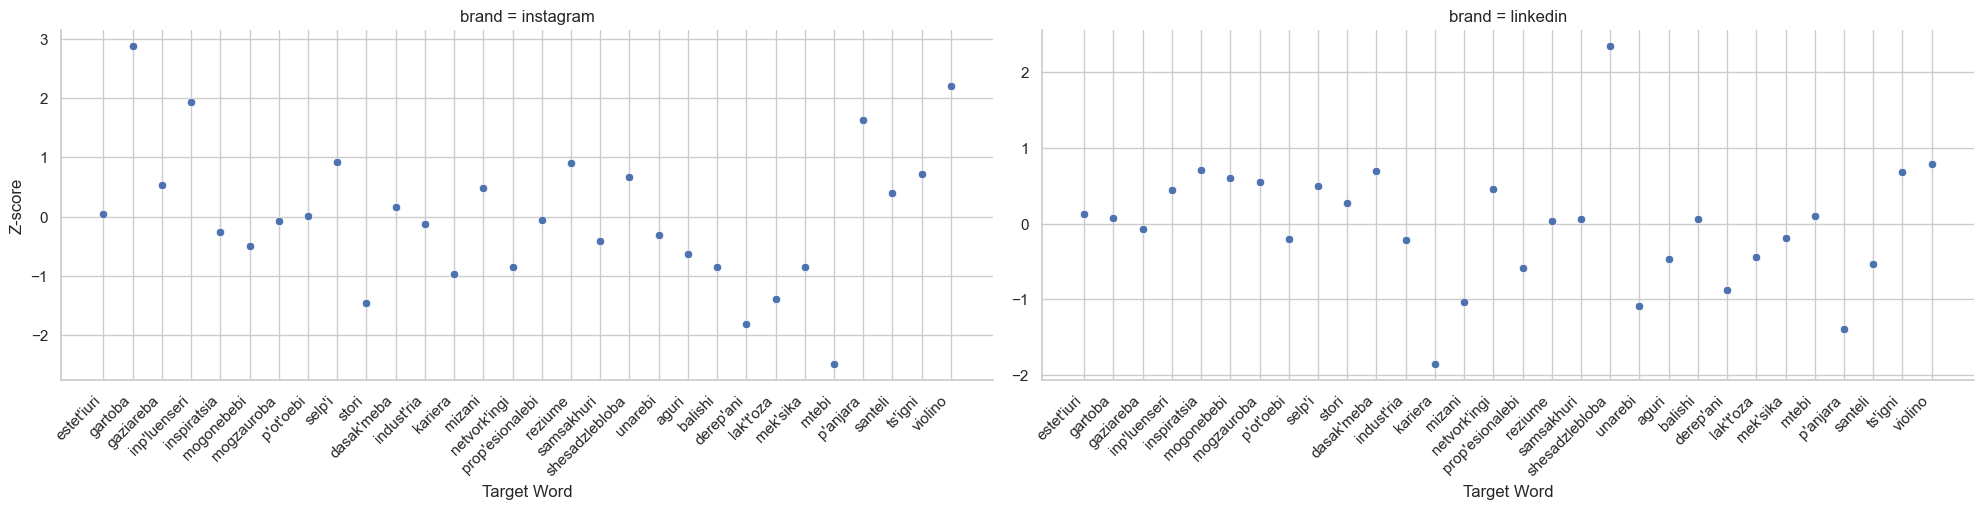

In [537]:
# Assuming pdata was created as described
# Reset index so 'brand' and 'target' become columns
pdata_reset = pdata.reset_index()

# Set plot style
sns.set(style="whitegrid")

# Alternative plot using zscore instead
g = sns.FacetGrid(pdata_reset, col="brand", height=5, sharey=False, aspect=2)
g.map_dataframe(sns.scatterplot, x="target_latin", y="zscore")
g.set_xticklabels(rotation=45, ha='right')
g.set_axis_labels("Target Word", "Z-score")
plt.subplots_adjust(hspace=0.3, bottom=0.25, top=0.95)
# plt.tight_layout()

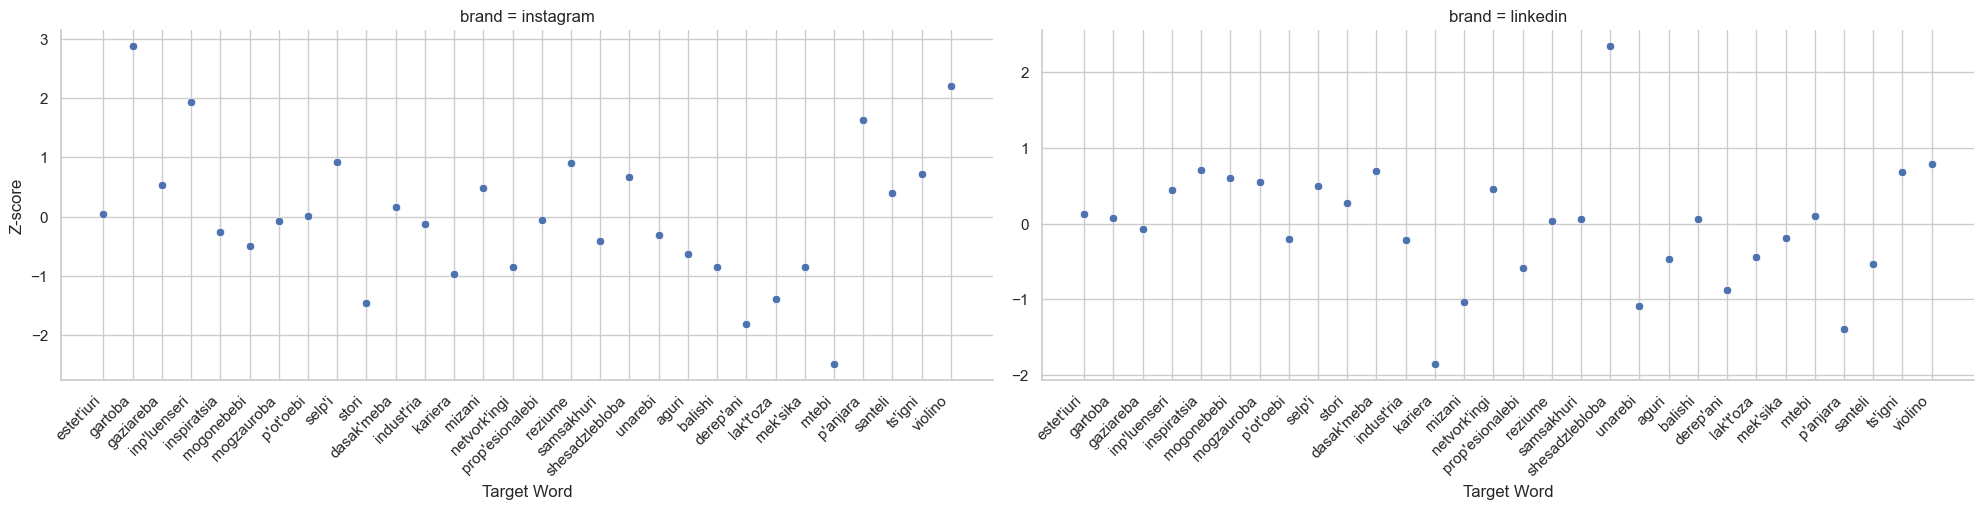

In [538]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming pdata was created as described
# Reset index so 'brand' and 'target' become columns
pdata_reset = pdata.reset_index()

# Set plot style
sns.set(style="whitegrid")

# Alternative plot using zscore instead
g = sns.FacetGrid(pdata_reset, col="brand", height=5, sharey=False, aspect=2)
g.map_dataframe(sns.scatterplot, x="target_latin", y="zscore")
g.set_xticklabels(rotation=45, ha='right')
g.set_axis_labels("Target Word", "Z-score")
plt.subplots_adjust(hspace=0.3, bottom=0.25, top=0.95)
# plt.tight_layout()

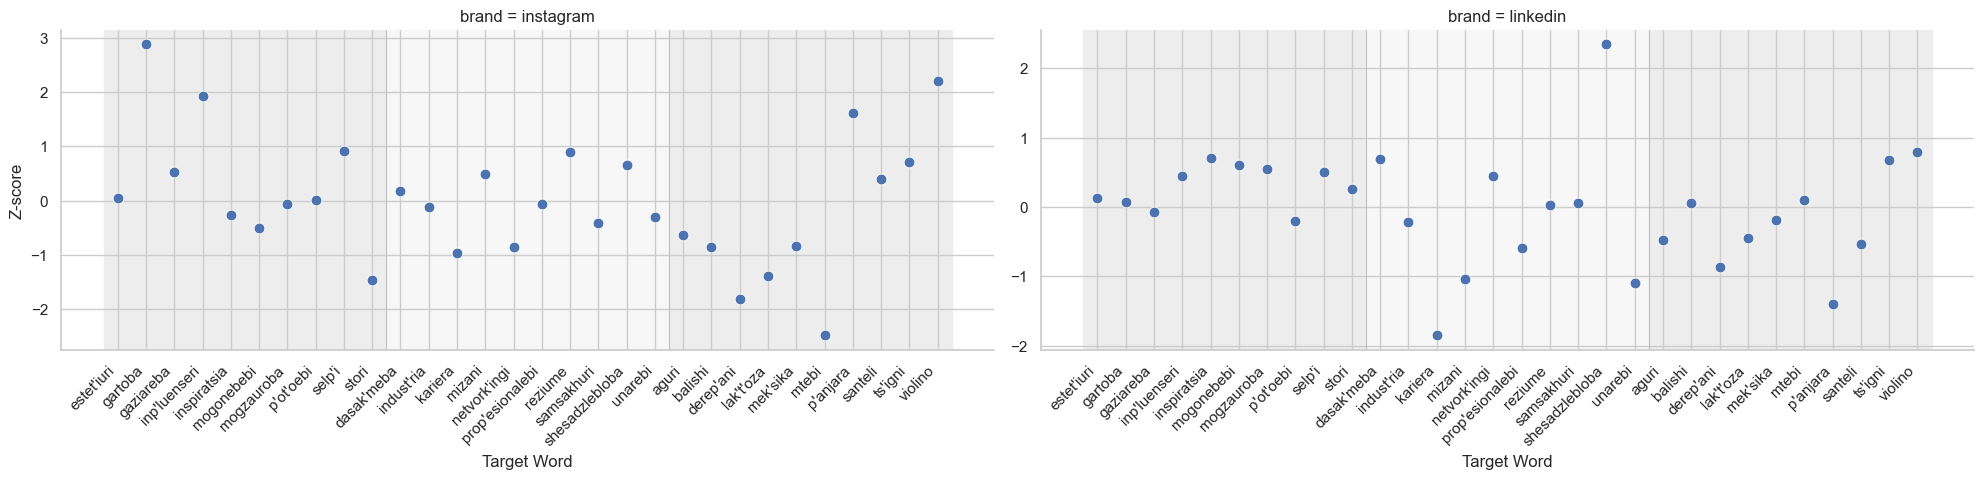

In [539]:
# Order targets by category and add category banding on the x-axis
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# pdata as in your code; reset for plotting
pdata_reset = pdata.reset_index()

# Category order
CAT_ORDER = ['instagram', 'linkedin', 'unrelated']

# Build target order within categories (alphabetical)
word_order = []
for c in CAT_ORDER:
    w = (pdata_reset.loc[pdata_reset['category'] == c, 'target_latin']
                     .drop_duplicates()
                     .sort_values(key=lambda s: s.str.lower()))
    word_order.extend(w.tolist())

# Encode ordered categories for x
pdata_reset['target_latin'] = pd.Categorical(pdata_reset['target_latin'],
                                             categories=word_order, ordered=True)
x_index = {w: i for i, w in enumerate(word_order)}
pdata_reset['x_pos'] = pdata_reset['target_latin'].map(x_index).astype(int)

# Precompute category intervals (start/end indices on x)
word2cat = dict(pdata_reset[['target_latin', 'category']].drop_duplicates().values)
bounds = []
start = 0
cur = word2cat[word_order[0]]
for i, w in enumerate(word_order):
    c = word2cat[w]
    if c != cur:
        bounds.append((cur, start, i - 1))
        cur, start = c, i
bounds.append((cur, start, len(word_order) - 1))

# Plot
sns.set(style="whitegrid")
g = sns.FacetGrid(pdata_reset, col="brand", height=5, sharey=False, aspect=2)
g.map_dataframe(sns.scatterplot, x="x_pos", y="zscore", s=60)

# Ax cosmetics: ticks, labels, category shading
for ax in g.axes.flat:
    # alternating category bands
    for j, (cat, a, b) in enumerate(bounds):
        ax.axvspan(a - 0.5, b + 0.5, color=str(0.93 + 0.04*(j % 2)), alpha=1.0, zorder=0)
        if j < len(bounds) - 1:
            ax.axvline(b + 0.5, color='0.75', lw=0.8, zorder=1)

    # ticks and ticklabels
    ax.set_xticks(np.arange(len(word_order)))
    ax.set_xticklabels(word_order, rotation=45, ha='right')

g.set_axis_labels("Target Word", "Z-score")
plt.subplots_adjust(hspace=0.35, bottom=0.28, top=0.92, wspace=0.05)
plt.show()